# NFSClustering
This notebook shows the process followed in order to generate a non-supervised clustering of NFS Research Awards Abstracts. The information was downloaded from [here](https://archive.ics.uci.edu/ml/datasets/NSF+Research+Award+Abstracts+1990-2003) into a directory called *Data* and preprocessed to a directory called *preparedData* using the *dataExtract.py* script.

We start importing all the necesary libraries

In [57]:
import spacy, glob, seaborn, string, numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

First, we load the preprocessed data into the *corpus* variable and filter all the empty or 'Not available' abstracts 

In [107]:
nlp = spacy.load('en_core_web_md')

corpus = []

for filename in glob.glob("preparedData/*.txt"):
    with open(filename, "r") as file:
        corpus.extend(file.readlines())

corpus = [x for x in corpus if len(x)>50]
corpus = [x.lower().strip() for x in corpus]
corpus = [x.translate(str.maketrans('', '', string.digits + string.punctuation)) for x in corpus]

print(f"Total abstract available {len(corpus)}")

Total abstract available 48674


In [108]:
data = []
for doc in nlp.pipe(corpus, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "ner"]):
    # Do something with the doc here
    tokenize_abstract =  [x for x in doc if (not x.is_stop) and (len(x.text) > 1)]
    data.append(tokenize_abstract)

<AxesSubplot:ylabel='Count'>

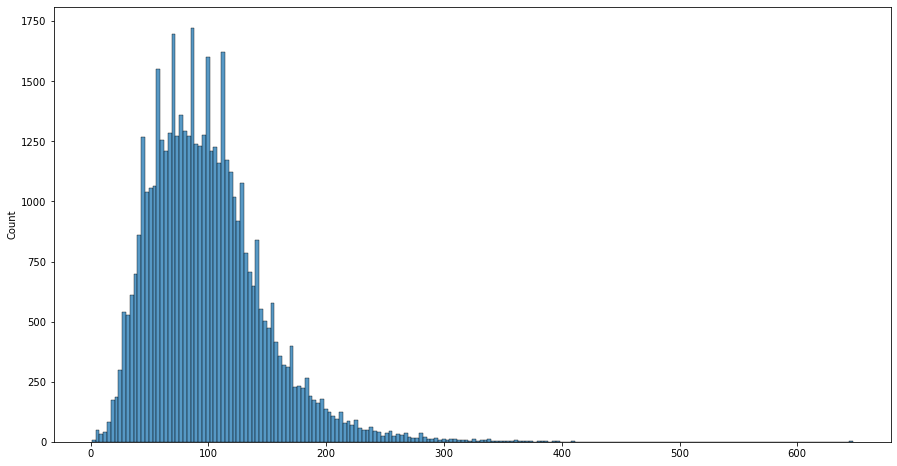

In [97]:
data_lengths = list(map(len, data))
plt.figure(figsize=(15,8))
seaborn.histplot(data_lengths)

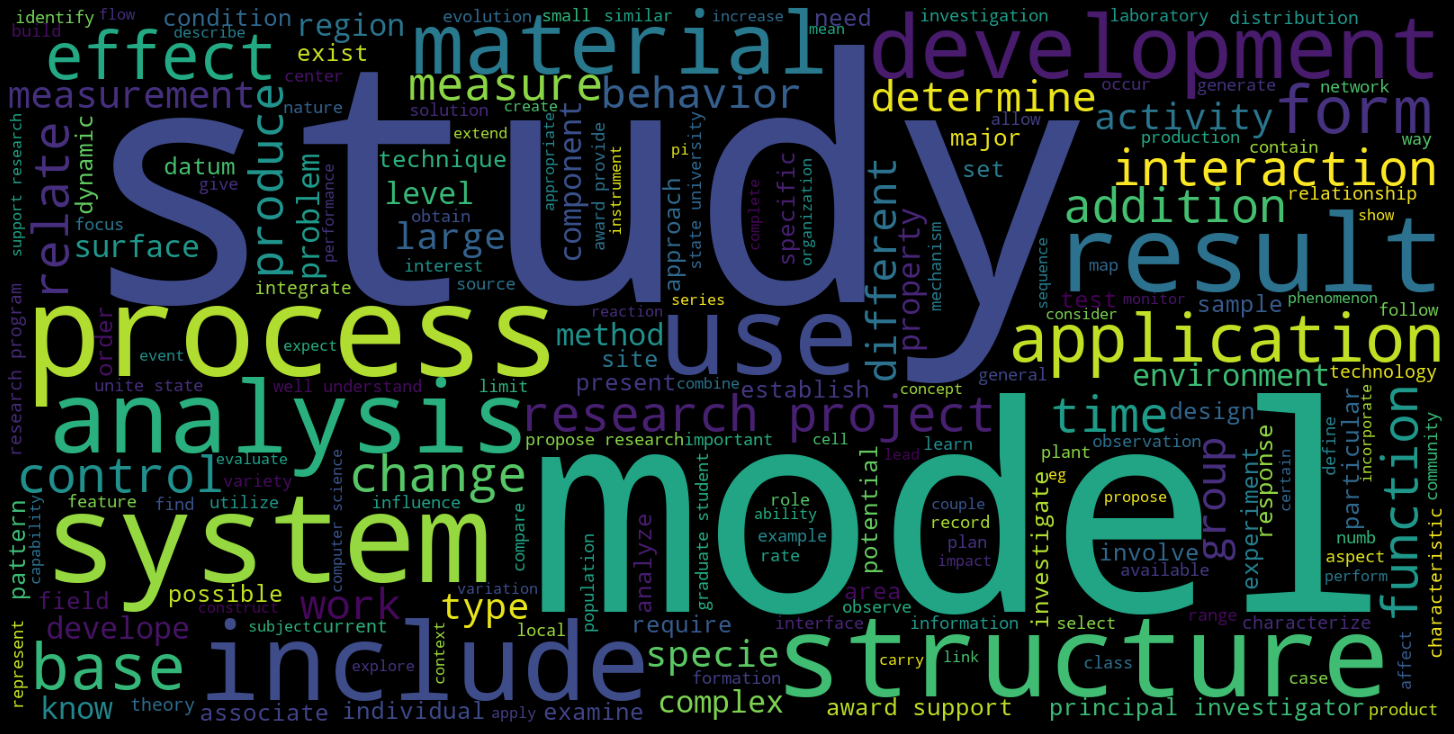

In [100]:
raw_data = " ".join([word.lemma_ for sentence in data for word in sentence])
wordcloud = WordCloud(width=1600, height=800).generate(raw_data)

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [35]:
word_embeddings = [word.vector for abstract in data for word in abstract]
abstracts_centroids = [np.mean(embeddings, axis=0) for embeddings in word_embeddings]

In [89]:
pca = PCA(n_components=50)
reduced_crentroids = pca.fit_transform(abstracts_centroids)
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Total variance explained {explained_variance:.{2}}")

Total variance explained 0.85


In [95]:
tsne = TSNE(perplexity=220, random_state=15, learning_rate=1000)
condensed_vectors = tsne.fit_transform(reduced_crentroids)

<AxesSubplot:>

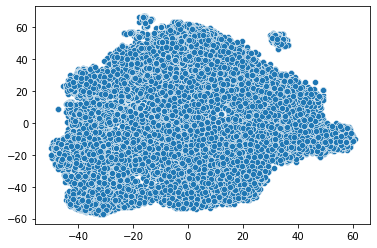

In [96]:
seaborn.scatterplot(x=condensed_vectors[:,0], y=condensed_vectors[:,1])

In [119]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_data = [" ".join([word.lemma_ for word in abstract]) for abstract in data]
tfidf_vectorizer = TfidfVectorizer(lowercase=False)
tfidf_embeddings = tfidf_vectorizer.fit_transform(tfidf_data)

In [120]:
tfidf_embeddings[0,:]

<1x113553 sparse matrix of type '<class 'numpy.float64'>'
	with 55 stored elements in Compressed Sparse Row format>

In [127]:
tfidf_embeddings.toarray()[0]

MemoryError: Unable to allocate 41.2 GiB for an array with shape (48674, 113553) and data type float64